In [0]:
import os
if os.name == 'nt':
    print('OS is Windows: PASS mount google drive')
    g_dir_work = '../colab/'
else:
    from google.colab import drive
    drive.mount('/content/drive')
    g_dir_work = '/content/drive/My Drive/colab/'

# check mount point
print('\n<< Display work dir >>')
for file in os.listdir(g_dir_work):
    print( 'file/dir : ', file)

import sys
if os.name == 'nt':# windows
    lib_path='../colab/mylib'
else:
    print(os.getcwd())
    lib_path='/content/drive/My Drive/colab/mylib/'
sys.path.append(lib_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

<< Display work dir >>
file/dir :  mylib
file/dir :  test.txt
file/dir :  data
file/dir :  template.ipynb
file/dir :  .ipynb_checkpoints
file/dir :  models
file/dir :  mnist_cams
file/dir :  mnist_pix2pix
file/dir :  tmp
/content


In [0]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test

def plot_mnist(n_ex=10,dim=(2,5), figsize=(8,4)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:, 0]
        #plt.imshow(img, cmap='binary')
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### 1.1 深層生成モデル

In [0]:
from tensorflow.keras.layers import Input, Reshape, Dense, Flatten, Activation, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def Generator():
    nch = 200
    model_input = Input(shape=[100])
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(model_input) # 100 -> 200*14*14
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x) # 200*14*14 -> 14x14x200 (width)x(height)x(channel)
    x = UpSampling2D(size=(2, 2))(x) # 14x14x200 -> 28x28x200
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x200 -> 28x28x100
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x100 -> 28x28x50
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x50 -> 28x28x1
    model_output = Activation('sigmoid')(x)
    model = Model(model_input, model_output)
    # model.summary()
    
    return model

In [0]:
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    model_input = Input(shape=shape) # 28x28x1
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(model_input) # 28x28x1 -> 14x14x256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x) # 14x14x256 -> 7x7x512
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x) # 7x7x512 -> 7*7*512
    x = Dense(256)(x) # 7*7*512 -> 256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x) # 256 -> 2
    model = Model(model_input, model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    x = generator(gan_input)
    gan_output = discriminator(x)
    model = Model(gan_input, gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [0]:
from tqdm import tqdm

def train(step=3000, BATCH_SIZE=128):
    step_per_epoch = int( X_train.shape[0] / BATCH_SIZE )
    for e in range(step): #tqdm(range(step)):
        if e % step_per_epoch  == 0:
          loss_disc = 0.0
          loss_gene = 0.0
        # 1. バッチの学習で利用する画像の選択 
        # バッチサイズの分だけランダムに画像を選択
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]
        
        # バッチサイズの分だけランダムにノイズを生成し、generatorにより画像を生成
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # 2. Discriminatorの学習をonに切り替える
        # Discriminatorが学習するように変更
        make_trainable(discriminator,True)
        
        # 3. Generatorによる生成画像を用いてDiscriminatorの学習
        # X = (バッチサイズ分のデータセットの画像, バッチサイズ分の生成画像)
        X = np.concatenate((image_batch, generated_images))
        
        # y = (バッチサイズ分のTrue(本物), バッチサイズ分のFalse(偽物))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1      
        
        # Discriminatorのtrain
        loss_disc += discriminator.train_on_batch(X,y)
        
        # 4. Discriminatorの学習をoffに切り替える
        # Discriminatorが学習しないように変更
        make_trainable(discriminator,False)
    
        # 5. Generatorの学習
        # バッチサイズの分だけランダムにノイズを生成
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        
        # y = (バッチサイズ分のTrue(本物))
        # 実際には生成した画像なのでDiscriminatorとしては偽物と判断すべきだが、Genaratorの学習なので生成した画像を本物と判断するように学習させる
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        # Generatorのtrain
        loss_gene += GAN.train_on_batch(noise_gen, y2 )
        
        if e % step_per_epoch == (step_per_epoch-1):
          print("[{0}][{1}] loss_disc={2:.3f}, loss_gene={3:.3f}".format(e+1, (e+1)/step_per_epoch, loss_disc, loss_gene) )


### 1.2.5 MNISTによる学習

In [0]:
# データのロード
X_train, _,_,_ = load_mnist()

# それぞれのネットワークのインスタンスを生成
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

W0825 08:12:36.684519 139709405849472 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
generator.summary()
discriminator.summary()
GAN.summary()

W0825 08:12:37.323873 139709405849472 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 39200)             3959200   
_________________________________________________________________
batch_normalization (BatchNo (None, 39200)             156800    
_________________________________________________________________
activation (Activation)      (None, 39200)             0         
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 200)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 200)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 100)       180100

In [0]:
train()

[468][1.0] loss_disc=11.803, loss_gene=21.485
[936][2.0] loss_disc=55.203, loss_gene=38.986
[1404][3.0] loss_disc=55.375, loss_gene=26.638
[1872][4.0] loss_disc=9.190, loss_gene=1.806
[2340][5.0] loss_disc=8.701, loss_gene=3.538
[2808][6.0] loss_disc=9.005, loss_gene=2.388


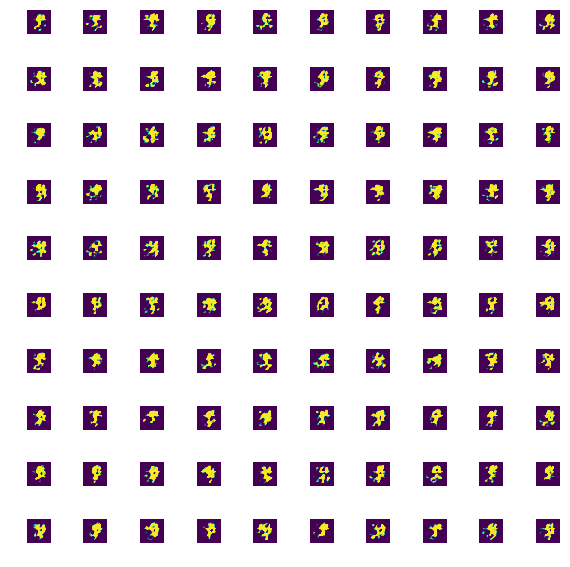

In [0]:
plot_mnist(n_ex=100, dim=(10,10), figsize=(8,8))

In [0]:
train()

In [0]:
plot_mnist(n_ex=100, dim=(10,10), figsize=(8,8))